# **ENSAMBLE LEARNING**

## **A. Various Type**

In [11]:
# Library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score

import warnings
warnings.filterwarnings('ignore')

In [12]:
# Load Data

churn = pd.read_csv('customer_churn.csv')
churn.head()

,Tenure,Total_Belanja_3bln,Hari_Terakhir_Login,Sesi_Per_Bulan,Jumlah_Tiket_Komplain,Skor_Kepuasan,Item_Wishlist,Churn
0,34.10,18.57,31.45,67.04,5.89,4.98,18.64,1
1,53.14,33.17,47.51,59.71,8.17,3.57,7.24,0
2,42.23,30.98,45.80,46.99,6.49,5.50,18.05,0
3,30.78,27.27,47.73,60.87,7.11,5.28,14.68,0
4,33.43,14.50,42.93,51.55,7.43,5.55,24.38,1


In [13]:
# Check Info

churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tenure                 1500 non-null   float64
 1   Total_Belanja_3bln     1500 non-null   float64
 2   Hari_Terakhir_Login    1500 non-null   float64
 3   Sesi_Per_Bulan         1500 non-null   float64
 4   Jumlah_Tiket_Komplain  1500 non-null   float64
 5   Skor_Kepuasan          1500 non-null   float64
 6   Item_Wishlist          1500 non-null   float64
 7   Churn                  1500 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 93.9 KB


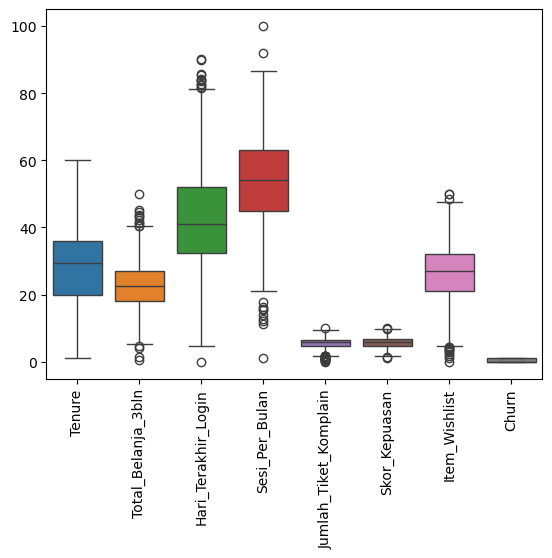

In [4]:
# Check Outliers

sns.boxplot(churn)
plt.xticks(rotation = 90)
plt.show()

In [14]:
# Split Data

x = churn.drop(columns='Churn')
y = churn['Churn']

xtrain, xtest, ytrain, ytest = train_test_split(x, y,
                                                stratify=y,
                                                random_state=42,
                                                test_size=0.2)

In [15]:
# Define KFold Untuk CrossVal

kfold = StratifiedKFold(random_state=42, n_splits=5, shuffle=True)

In [16]:
# PreProcessing

prepos = ColumnTransformer(transformers=[
    ('Scaler', RobustScaler(), ['Tenure', 'Total_Belanja_3bln', 'Hari_Terakhir_Login', 'Sesi_Per_Bulan',
                                'Jumlah_Tiket_Komplain', 'Skor_Kepuasan', 'Item_Wishlist']),
], remainder='passthrough')

prepos

ColumnTransformer(remainder='passthrough',
                  transformers=[('Scaler', RobustScaler(),
                                 ['Tenure', 'Total_Belanja_3bln',
                                  'Hari_Terakhir_Login', 'Sesi_Per_Bulan',
                                  'Jumlah_Tiket_Komplain', 'Skor_Kepuasan',
                                  'Item_Wishlist'])])

In [ ]:
# Model benchmarking (Recall fokus pada kelas positif)

dt = DecisionTreeClassifier(random_state=42, max_depth=None)
rf = RandomForestClassifier(random_state=42)
logreg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
svm = SVC()
bagging = BaggingClassifier(SVC(), n_estimators=100, random_state=42)

hard = VotingClassifier(estimators=[
    ('DT', DecisionTreeClassifier()),
    ('RF', RandomForestClassifier()),
    ('LogReg', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC())
], voting='hard')

soft = VotingClassifier(estimators=[
    ('DT', DecisionTreeClassifier()),
    ('RF', RandomForestClassifier()),
    ('LogReg', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC())
], voting='soft')

stacking = StackingClassifier(estimators=[
    ('DT', DecisionTreeClassifier()),
    ('RF', RandomForestClassifier()),
    ('LogReg', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC())
], final_estimator=RandomForestClassifier(), cv=kfold)

# Tambahkan bagging ke daftar model agar panjang list konsisten
model = [dt, rf, logreg, knn, svm, hard, soft, stacking, bagging]
score_mean = []
score_std = []

for m in model:
    pipe = Pipeline([
        ('Preprocesing', prepos),
        ('Model', m)
    ])

    cv_score = cross_val_score(pipe,
                               xtrain, ytrain,
                               cv=kfold,
                               scoring='recall')

    score_mean.append(round(cv_score.mean(), 5))
    score_std.append(round(cv_score.std(), 5))

rangkuman = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'LogReg', 'KNN', 'SVM', 'Hard Voting', 'Soft Voting', 'Stacking', 'Bagging (SVC)'],
    'Score AVG': score_mean,
    'Score STD': score_std
}).sort_values('Score AVG', ascending=False)

rangkuman = 

rangkuman

,Model,Score AVG,Score STD
3,KNN,0.90646,0.03068
1,Random Forest,0.89819,0.03083
8,Bagging (SVC),0.89482,0.03401
5,Hard Voting,0.89482,0.02669
7,Stacking,0.89480,0.03239
4,SVM,0.89148,0.03028
0,Decision Tree,0.86310,0.03862
2,LogReg,0.85808,0.05060
6,Soft Voting,NaN,NaN


**NEXT STEP**
- Dari Model Yang Memiliki Performa Mirip, Silahkan Di Test Ke Data Test
- Ambil 2 Model Terbaik Setelah Diuji Ke Data Test
- Tunning 2 Model Tersebut
- Pick Best Model Untuk Dilakukan Deployment